In [1]:
import pandas as pd
import os
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV 


In [2]:
# Directorio base
base_dir = os.path.join('..','data', 'train_test_val')

# Cargar los DataFrames
train_df = pd.read_csv(os.path.join(base_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(base_dir, 'test.csv'))
val_df = pd.read_csv(os.path.join(base_dir, 'val.csv'))

# Declaracion de la variable objetivo
target = 'income'

In [14]:
train_df.skew()

age                                      0.547411
fnlwgt                                   0.411025
educational-num                         -0.306005
gender                                   0.708244
hours-per-week                           0.244882
income                                   1.215766
capital_gain                             3.111021
capital_loss                             4.227281
workclass_Local-gov                      3.507708
workclass_Never-worked                  74.292215
workclass_Private                       -1.150993
workclass_Self-emp-inc                   5.059625
workclass_Self-emp-not-inc               3.107407
workclass_State-gov                      4.681559
workclass_Without-pay                   48.618047
marital-status_Married-AF-spouse        38.769722
marital-status_Married-civ-spouse        0.163480
marital-status_Married-spouse-absent     8.733868
marital-status_Never-married             0.734935
marital-status_Separated                 5.355275


In [3]:
X_train = train_df.drop(columns=[target])
y_train = train_df[target]

X_val = val_df.drop(columns=[target])
y_val = val_df[target]

X_test = test_df.drop(columns=[target])
y_test = test_df[target]

In [4]:
#definimos el modelo
model =LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7961, number of negative: 25170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 33131, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240289 -> initscore=-1.151098
[LightGBM] [Info] Start training from score -1.151098


LGBMClassifier(random_state=42)

In [5]:
y_train_pred = model.predict(X_train)
print("--- Entrenamiento ---")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print("F1 (train):", f1_score(y_train, y_train_pred))
print("--- Validacion ---")
y_val_pred = model.predict(X_val)
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print("F1:", f1_score(y_val, y_val_pred))

--- Entrenamiento ---
[[23919  1251]
 [ 2584  5377]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     25170
           1       0.81      0.68      0.74      7961

    accuracy                           0.88     33131
   macro avg       0.86      0.81      0.83     33131
weighted avg       0.88      0.88      0.88     33131

F1 (train): 0.7371307149222016
--- Validacion ---
[[5090  304]
 [ 560 1146]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      5394
           1       0.79      0.67      0.73      1706

    accuracy                           0.88      7100
   macro avg       0.85      0.81      0.82      7100
weighted avg       0.87      0.88      0.87      7100

F1: 0.7262357414448669


In [6]:
weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model2 = LGBMClassifier(random_state=42, scale_pos_weight=weight, learning_rate=0.05, max_depth=10, n_estimators=1000, num_leaves=31, colsample_bytree=0.8, subsample=0.8, min_child_samples=20)
model2.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7961, number of negative: 25170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 33131, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240289 -> initscore=-1.151098
[LightGBM] [Info] Start training from score -1.151098


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=10,
               n_estimators=1000, random_state=42,
               scale_pos_weight=3.1616631076497925, subsample=0.8)

In [7]:
y_train_pred2 = model2.predict(X_train)
print("--- Entrenamiento ---")
print(confusion_matrix(y_train, y_train_pred2))
print(classification_report(y_train, y_train_pred2))
print("F1 (train):", f1_score(y_train, y_train_pred2))
print("--- Validacion ---")
y_val_pred2 = model2.predict(X_val)
print(confusion_matrix(y_val, y_val_pred2))
print(classification_report(y_val, y_val_pred2))
print("F1:", f1_score(y_val, y_val_pred2))

--- Entrenamiento ---
[[22012  3158]
 [  386  7575]]
              precision    recall  f1-score   support

           0       0.98      0.87      0.93     25170
           1       0.71      0.95      0.81      7961

    accuracy                           0.89     33131
   macro avg       0.84      0.91      0.87     33131
weighted avg       0.92      0.89      0.90     33131

F1 (train): 0.8104204557612068
--- Validacion ---
[[4569  825]
 [ 275 1431]]
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      5394
           1       0.63      0.84      0.72      1706

    accuracy                           0.85      7100
   macro avg       0.79      0.84      0.81      7100
weighted avg       0.87      0.85      0.85      7100

F1: 0.7223624432104997


Probamos con la tecnica de oversampling a ver si conseguimos mejores resultados.

In [8]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [9]:
model3 = LGBMClassifier(random_state=42, scale_pos_weight=weight, learning_rate=0.05, max_depth=10, n_estimators=1000, num_leaves=31, colsample_bytree=0.8, subsample=0.8, min_child_samples=20)
model3.fit(X_res, y_res)

[LightGBM] [Info] Number of positive: 25170, number of negative: 25170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7847
[LightGBM] [Info] Number of data points in the train set: 50340, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=10,
               n_estimators=1000, random_state=42,
               scale_pos_weight=3.1616631076497925, subsample=0.8)

In [10]:
y_train_pred3 = model3.predict(X_res)
print("--- Entrenamiento ---")
print(confusion_matrix(y_res, y_train_pred3))
print(classification_report(y_res, y_train_pred3))
print("F1 (train):", f1_score(y_res, y_train_pred3))
print("--- Validacion ---")
y_val_pred3 = model3.predict(X_val)
print(confusion_matrix(y_val, y_val_pred3))
print(classification_report(y_val, y_val_pred3))
print("F1:", f1_score(y_val, y_val_pred3))

--- Entrenamiento ---
[[21821  3349]
 [  400 24770]]
              precision    recall  f1-score   support

           0       0.98      0.87      0.92     25170
           1       0.88      0.98      0.93     25170

    accuracy                           0.93     50340
   macro avg       0.93      0.93      0.93     50340
weighted avg       0.93      0.93      0.93     50340

F1 (train): 0.9296477697085702
--- Validacion ---
[[4549  845]
 [ 246 1460]]
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      5394
           1       0.63      0.86      0.73      1706

    accuracy                           0.85      7100
   macro avg       0.79      0.85      0.81      7100
weighted avg       0.87      0.85      0.85      7100

F1: 0.7279980054849164


Observamos que con la tecnica de SMOTE mejora significativamente, aumenta la precision, el f1-score y recall en la clase minoritaria, y en validacion conseguimos que disminuyan los fasos negativos y aumenten las metricas. Realizaremos un gridsearch para ver si podemos optimizar aun mas los hiperparametros.

Observamos que sigue habiendo un overfitting claro por lo que vamos a intentar reducirlo disminuyen la profundidad del arbol(max_depth) y num_leaves

In [22]:
model4 = LGBMClassifier(random_state=42, scale_pos_weight=weight, learning_rate=0.05, max_depth=7, n_estimators=1000, num_leaves=25, colsample_bytree=0.8, subsample=0.8, min_child_samples=50)
model4.fit(X_res, y_res)

[LightGBM] [Info] Number of positive: 25170, number of negative: 25170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7847
[LightGBM] [Info] Number of data points in the train set: 50340, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7,
               min_child_samples=50, n_estimators=1000, num_leaves=25,
               random_state=42, scale_pos_weight=3.1616631076497925,
               subsample=0.8)

In [23]:
y_train_pred4 = model4.predict(X_res)
print("--- Entrenamiento ---")
print(confusion_matrix(y_res, y_train_pred4))
print(classification_report(y_res, y_train_pred4))
print("F1 (train):", f1_score(y_res, y_train_pred4))
print("--- Validacion ---")
y_val_pred4 = model4.predict(X_val)
print(confusion_matrix(y_val, y_val_pred4))
print(classification_report(y_val, y_val_pred4))
print("F1:", f1_score(y_val, y_val_pred4))

--- Entrenamiento ---
[[21405  3765]
 [  567 24603]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     25170
           1       0.87      0.98      0.92     25170

    accuracy                           0.91     50340
   macro avg       0.92      0.91      0.91     50340
weighted avg       0.92      0.91      0.91     50340

F1 (train): 0.9190855093578393
--- Validacion ---
[[4502  892]
 [ 225 1481]]
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      5394
           1       0.62      0.87      0.73      1706

    accuracy                           0.84      7100
   macro avg       0.79      0.85      0.81      7100
weighted avg       0.87      0.84      0.85      7100

F1: 0.7261583721500368


Me gustaria haber probado con early stopping pero me daba un error de que no lo podia añadir al modelo por la version(tampoco me dejo con callbacks)

### Optimizacion de hiperparametros

In [11]:
from sklearn.model_selection import RandomizedSearchCV

In [25]:
param_dist = {
    'num_leaves': [15, 31, 63],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [10, 20, 50],
    'scale_pos_weight':  [1, 2, 3, 4]
    
}

random_search = RandomizedSearchCV(
    estimator=model3,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_res, y_res)
print("Mejores hiperparámetros: ", random_search.best_params_)
print("Mejor score: ", random_search.best_score_)

# Mejor modelo encontrado
best_model = random_search.best_estimator_

# Evaluación sobre el conjunto de validación
print("Mejor score (en validación): ", best_model.score(X_val, y_val))

# Predicción sobre el conjunto de validación
y_val_pred = best_model.predict(X_val)

# Métricas de evaluación
print("F1 en validación:", f1_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 25170, number of negative: 25170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7847
[LightGBM] [Info] Number of data points in the train set: 50340, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Mejores hiperparámetros:  {'subsample': 0.8, 'scale_pos_weight': 4, 'num_leaves': 63, 'n_estimators': 100, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Mejor score:  0.819079508908611
Mejor score (en validación):  0.7570422535211268
F1 en validación: 0.6494614915667547
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.70      0.8

Observamos que los resultados despues de eusar el randimized search no han sido los adecuados por lo que vamos a buscar con uno mas esècifico como el gridsearch

#### GridSearch

In [28]:
#vamos a hacer una busqueda de hiperparametros con GridSearchCV
# Definimos el modelo

param_grid = {
    'num_leaves': [20, 25],
    'max_depth': [7, 8],
    'learning_rate': [0.03],
    'n_estimators': [700, 1000],
    'subsample': [0.7],
    'colsample_bytree': [0.8],
    'min_child_samples': [30, 50]
}

base_model = LGBMClassifier(random_state=42, scale_pos_weight=3.16)
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='f1', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_res, y_res)
print("Mejores hiperparámetros: ", grid_search.best_params_)
print("Mejor score: ", grid_search.best_score_)
# Mejor modelo encontrado
best_model = grid_search.best_estimator_
# Evaluación sobre el conjunto de validación
print("Mejor score (en validación): ", best_model.score(X_val, y_val))
# Predicción sobre el conjunto de validación
y_val_pred5 = best_model.predict(X_val)
# Métricas de evaluación
print("F1 en validación:", f1_score(y_val, y_val_pred5))
print("Classification Report:\n", classification_report(y_val, y_val_pred5))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Number of positive: 25170, number of negative: 25170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7847
[LightGBM] [Info] Number of data points in the train set: 50340, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [29]:
y_test_pred = best_model.predict(X_test)
print("--- Test ---")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("F1 (test):", f1_score(y_test, y_test_pred))

--- Test ---
[[4359 1035]
 [ 224 1482]]
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      5394
           1       0.59      0.87      0.70      1706

    accuracy                           0.82      7100
   macro avg       0.77      0.84      0.79      7100
weighted avg       0.86      0.82      0.83      7100

F1 (test): 0.7018707080274686


## Conclusiones

- Se dividió el dataset en entrenamiento (70%), validación (15%) y test (15%) de forma estratificada por el desbalanceo.
- Se utilizó un modelo de LightGBMClassifier, ajustando hiperparámetros con GridSearchCV y RandomizedSearch.
- El modelo final tuvo un buen rendimiento general:
  - F1 en test: 0.7

- No se detectó exceso de overfitting, ya que el rendimiento en entrenamiento, validación y test fue consistente.


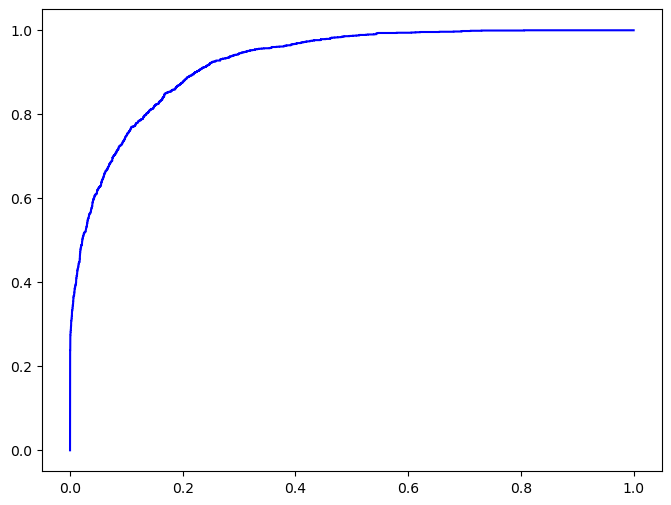

In [30]:
#Curva ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
import numpy as np

# Predecir las probabilidades de la clase positiva
y_test_proba = best_model.predict_proba(X_test)[:, 1]
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc))

In [32]:
import pickle
with open(r'../artifacts/lightgbm.pkl', "wb") as f:
    pickle.dump(best_model, f)